# Distortion Classification

In [1]:
import torch
import torchaudio
import os

#### Add Tensorboard to record data

In [2]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_classify_od"
LOG_DIR = "_log/" + EXPERIMENT_NAME

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

log_writer = SummaryWriter(LOG_DIR)


### Load dataset

Using device cpu
There are 195 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


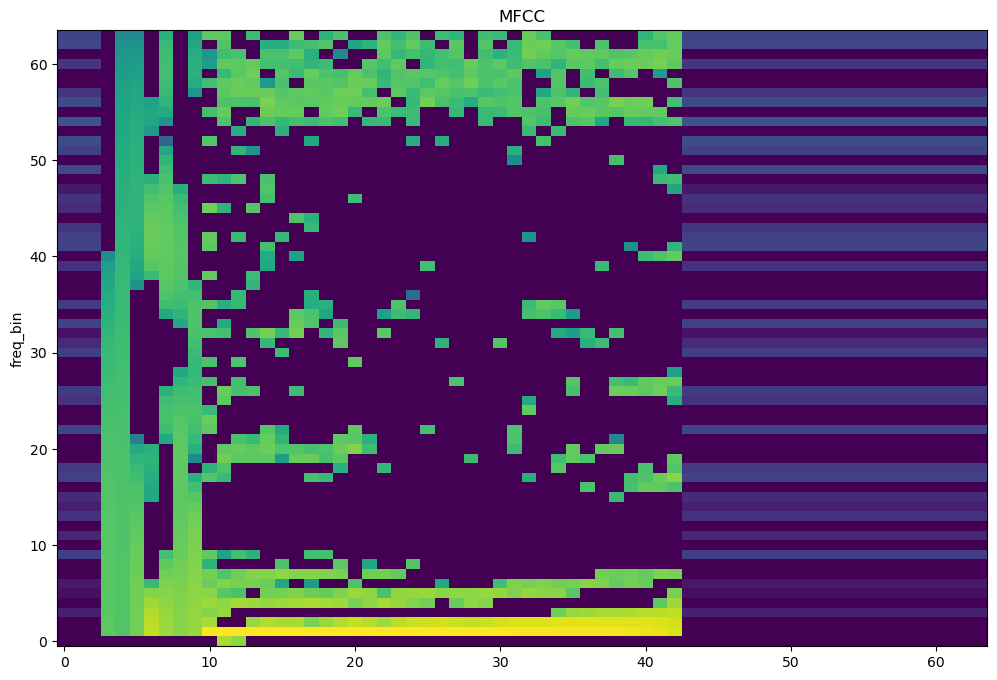

In [3]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram

AUDIO_DIR = "_assets/DATASET/GT-FX-SINGLE/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

signal, _, _, _, filename = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")

print("input feature:")
log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))

#### Split dataset into train and test sets

In [4]:
from src.classifier import train

BATCH_SIZE = round(len(fxData) / 200)

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

#### Model training

In [5]:
from src.classifier import model
from torch import nn

LEARNING_RATE = 0.0002
EPOCHS = 10

# construct model and assign it to device
cnn = model.SingleClassifier().to(device)

log_writer.add_graph(cnn, signal.unsqueeze_(0))

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            log_writer,
            EPOCHS,
            mode="single")


Epoch 1
loss: 0.778496  [  0/157]
loss: 2.153429  [ 20/157]
loss: 0.048172  [ 40/157]
loss: 0.654056  [ 60/157]
loss: 1.151606  [ 80/157]
loss: 0.033186  [100/157]
loss: 0.361674  [120/157]
loss: 0.005647  [140/157]
Accuracy: 84.2%, avg loss: 0.235611
learning rate: 0.000200 -> 0.000182
---------------------------

Epoch 2
loss: 0.013304  [  0/157]
loss: 0.733365  [ 20/157]
loss: 0.003968  [ 40/157]
loss: 0.006876  [ 60/157]
loss: 0.002074  [ 80/157]
loss: 0.014765  [100/157]
loss: 0.129374  [120/157]
loss: 0.214141  [140/157]
Accuracy: 94.7%, avg loss: 0.089678
learning rate: 0.000182 -> 0.000164
---------------------------

Epoch 3
loss: 0.002244  [  0/157]
loss: 0.053377  [ 20/157]
loss: 0.000372  [ 40/157]
loss: 0.024922  [ 60/157]
loss: 0.199007  [ 80/157]
loss: 0.000455  [100/157]
loss: 0.001050  [120/157]
loss: 0.000625  [140/157]
Accuracy: 100.0%, avg loss: 0.051644
learning rate: 0.000164 -> 0.000146
---------------------------

Epoch 4
loss: 0.001273  [  0/157]
loss: 0.003689

#### Save model weight and bias

In [6]:
WEIGHTS_DIR = "_weights/"
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME + ".pth")

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# save model
torch.save(cnn.state_dict(), WEIGHTS_FILE)
print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

Trained feed forward net saved at _weights/c53_classify_rr.pth


#### Evaluation

Accuracy: 100.0%, avg loss: 0.010418
[[ 5  0]
 [ 0 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        14

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



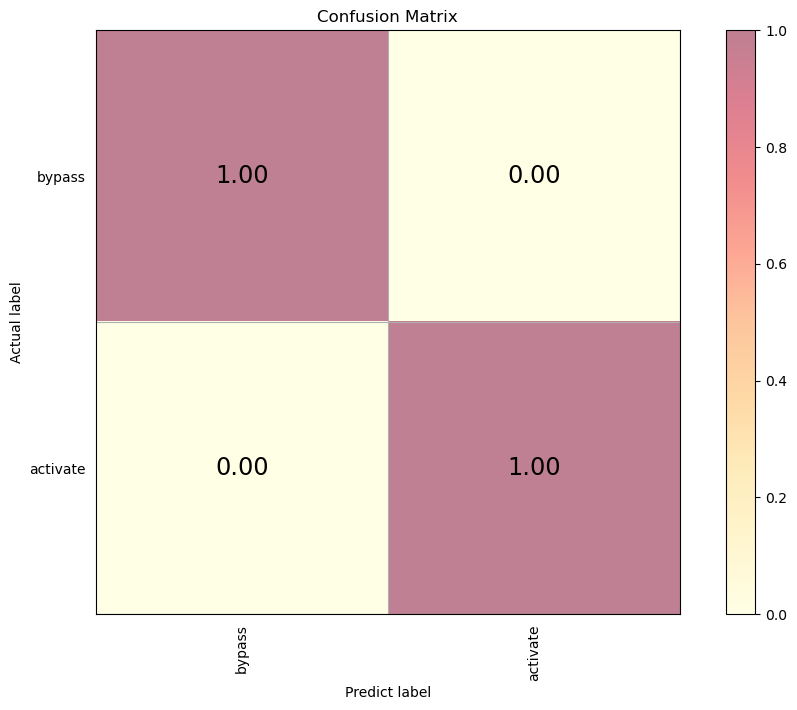

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix

labels_ID = ['bypass', 'activate']

cnn = model.SingleClassifier().to(device)

state_dict = torch.load(WEIGHTS_FILE)
cnn.load_state_dict(state_dict)

_, _, log = train.test(cnn, val_dataloader, device, mode="single")

expected = []
predicted = []
for index, data in enumerate(log):
    predicted.append(data[1])
    expected.append(data[2])

mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
print(mat_con)
print(classification_report(expected, predicted))

log_writer.add_figure("Confusion Matrix", plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID))

log_writer.close()